## Imports

In [93]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Pipeline and transformers
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline, FeatureUnion

# ML Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# DL
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

# regex
import re

In [10]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sab0taj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Read and Visualize Dataset

In [11]:
df = pd.read_csv('twitter_data.csv', header=None)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [12]:
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [13]:
# drop unnecessary columns
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)

In [14]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   text       1600000 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [15]:
decode_map = {0: "Negative", 2: "Neutral", 4: "Positive"}

def decode_sentiment(label):
    return decode_map[int(label)]


df.sentiment = df.sentiment.apply(lambda x: decode_sentiment(x))

df.head()

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


Text(0.5, 1.0, 'Sentiment Data Distribution')

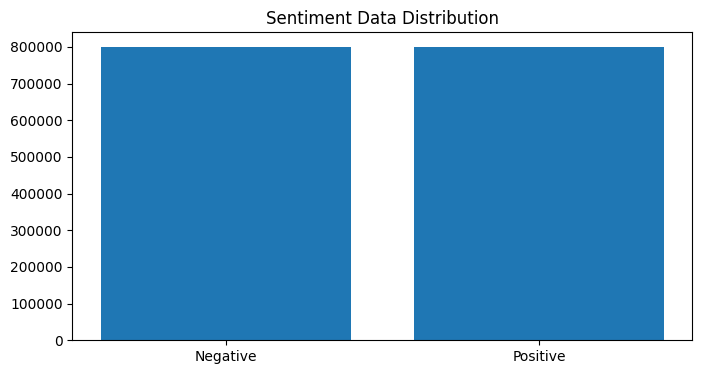

In [16]:
val_count = df.sentiment.value_counts()
plt.figure(figsize=(8, 4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [17]:
df.sample(frac=1)

,sentiment,text
765482,Negative,@al_pari shit upppp I can't do itttt on my phone
1412313,Positive,Having a cappuccino and my daughter is doing m...
522538,Negative,"now that my car is back in NJ, i can't go to b..."
459968,Negative,Having a shattered iPhone screen is depressing...
413782,Negative,@Domzie arrrggghghhghghghg this is Domzie n Me...
...,...,...
933416,Positive,woohoo! It took three hours but I finally beat...
914081,Positive,contemplating whether or not I will go to prom...
686199,Negative,"wants the hawk back, caught a mouse today"
1415278,Positive,Runyon Canyon


## Pre-process
We want to get clean up our data by doing the following:
- Lowercasing
- Removing stopwords such as 'the' and 'a'
- Removing links, usernames, hashtags
- Replacing emojis
- Removing unknown words
- Changing words with repeated characters such as 'cooool'
- Lemmatization: reducing a particular word to it's simplest form
    - ex) corpora -> corpus


In [18]:
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked', ':-$': 'confused', ':\\': 'annoyed',
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
          ';-)': 'wink', 'O:-)': 'angel', 'O*-)': 'angel', '(:-D': 'gossip', '=^.^=': 'cat'
        }

# Defining different regex to handle preprocessing
url = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
user = '@[^\s]+'
alpha = "[^a-zA-Z0-9]"
sequence = r"(.)\1\1+"
seqReplace = r"\1\1"

In [19]:
def preprocess(data):
    processedTweet = []
    for tweet in data:
        # 1. lowercase every word
        tweet = tweet.lower()
        
        # 2. replacing all urls with the word 'URL' and usernames with the word 'USERNAME'
        tweet = re.sub(url, ' URL', tweet)
        
        # 3. replacing all emojis
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, ' EMOJI' + emojis[emoji])
            
        # 4. replacing @usernames with 'USER'
        tweet = re.sub(user, ' USER', tweet)
        
        #5. removing non alphanumeric words
        tweet = re.sub(alpha, ' ', tweet)
        
        # 6. lemmatizing a word
        lemmatizedTweet = ''
        for word in tweet.split():
            lemmatizedTweet += (lemmatizer.lemmatize(word) + ' ')
            
        processedTweet.append(lemmatizedTweet.strip())

    return processedTweet
        

In [20]:
df.text = preprocess(df.text)
print('Text Preprocessing complete.')

Text Preprocessing complete.


## Visualizing Processed Data

In [98]:
from wordcloud import WordCloud

Word Cloud for Positive Tweets

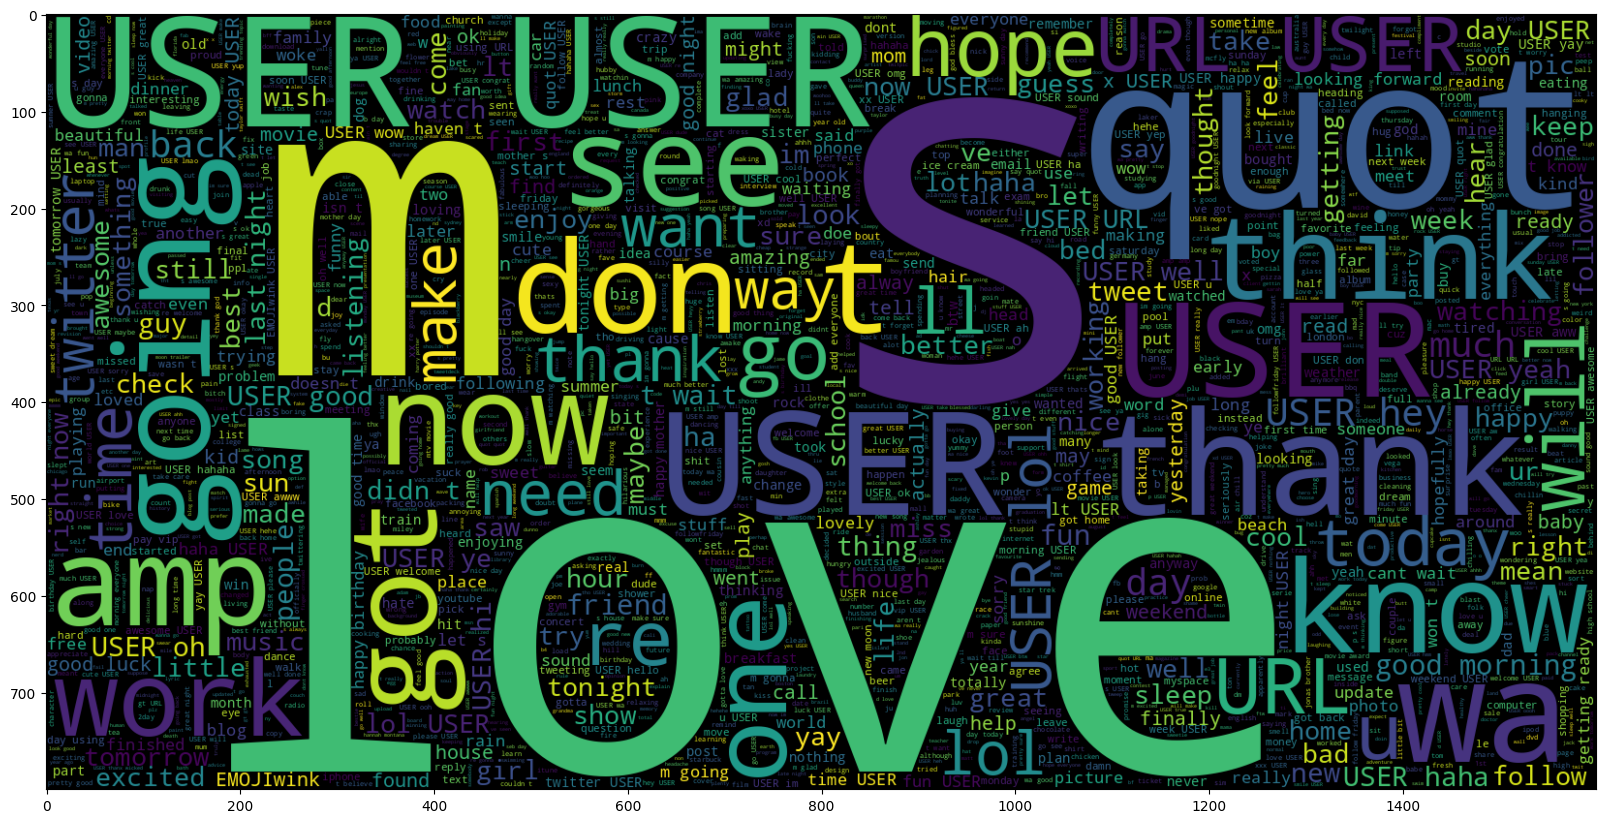

In [100]:
plt.figure(figsize=(20, 20))
wc = WordCloud(max_words=2000, width=1600, height=800).generate(" ".join(df[df.sentiment == 'Positive'].text))
plt.imshow(wc, interpolation='bilinear')

Word Cloud for Negative Tweets

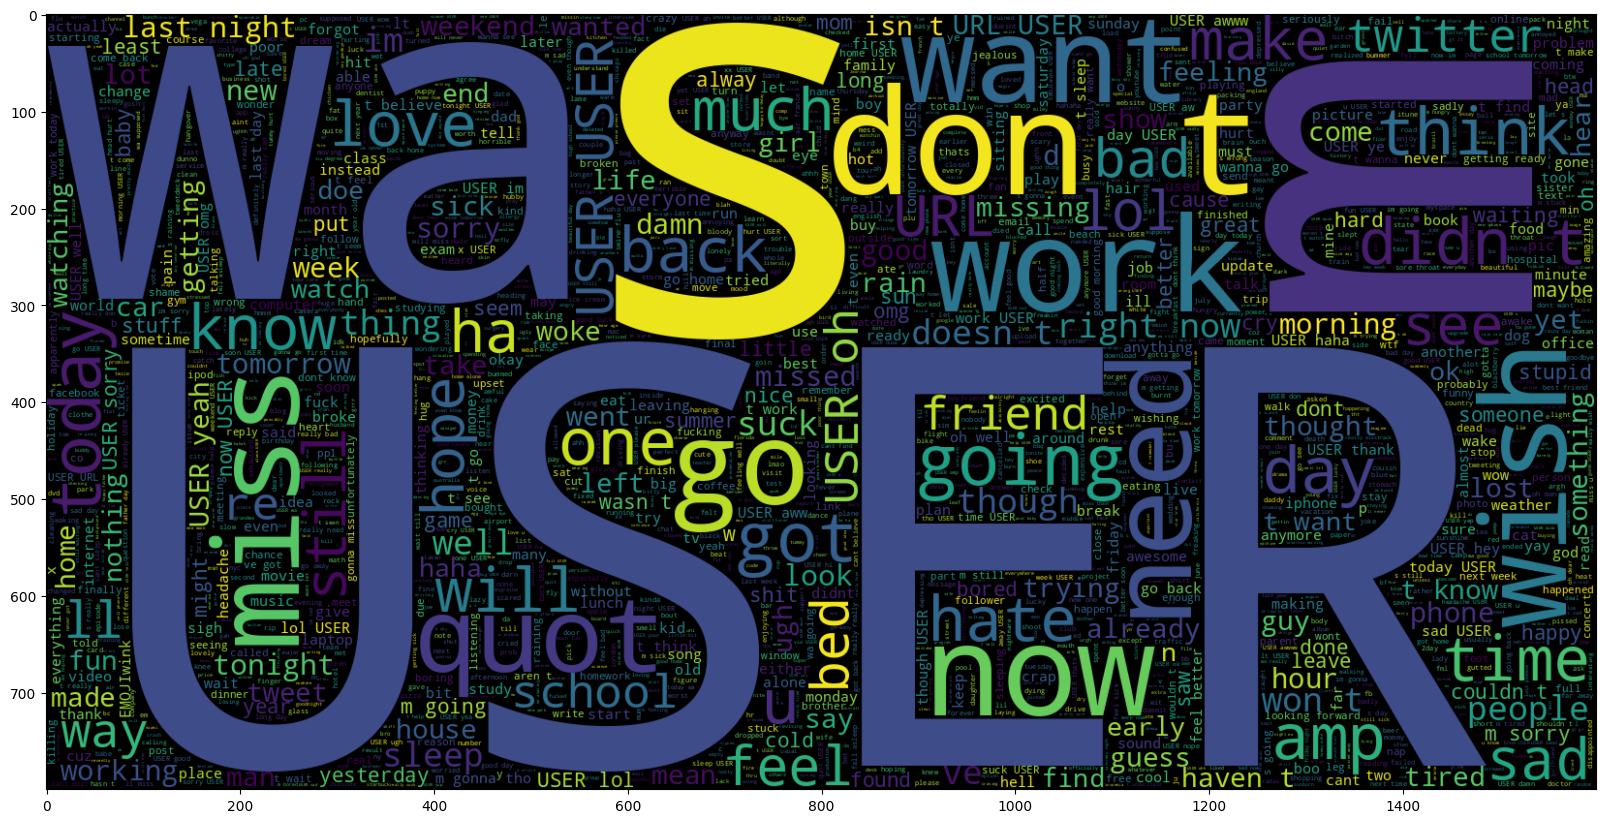

In [16]:
plt.figure(figsize=(20, 20))
wc = WordCloud(max_words=2000, width=1600, height=800).generate(" ".join(df[df.sentiment == 'Negative'].text))
plt.imshow(wc, interpolation='bilinear')

## Splitting the Data

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.sentiment, test_size=0.2, random_state=0)

# Machine Learning Methods

## Feature Extraction
I will be training my models based on the following features:
- TF-IDF
- Bag of Words

In [22]:
# Combine features
combined_features = FeatureUnion([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_features=500000)),
    ('bow', CountVectorizer()),
])

## Helper Functions
Creating helper function to evaluate the models and visualize results

In [53]:
def evaluateModel(model, testData):
    # predicts values for the test data
    y_pred = model.predict(testData)
    
    # prints the metrics of the model
    print(classification_report(y_test, y_pred))
    
    return y_pred

In [42]:
def createConfusionMatrix(pred, modelName):
    cf_matrix = confusion_matrix(y_test, pred)

    categories = ['Negative', 'Positive']
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    sns.heatmap(cf_matrix, annot=labels, cmap='Blues', fmt='', xticklabels=categories, yticklabels=categories)

    plt.xlabel("Predicted values", fontdict={'size': 14}, labelpad=10)
    plt.ylabel("Actual values", fontdict={'size': 14}, labelpad=10)
    plt.title ("Confusion Matrix for " + modelName + " Model" , fontdict = {'size': 18}, pad = 20) 

In [26]:
def createPipeline(model):
    # create pipeline
    pipeline = Pipeline([
        ('features', combined_features),
        ('classifier', model)
    ])
    
    # training the model
    pipeline.fit(X_train, y_train)
    
    return pipeline

## Models
Testing 2 different features for 3 different models: 
- SVM Classifier with a liner kernel
- Multinomial Naive Bayes
- Decision Tree Classifier

### SVM Classifier

In [27]:
# initialize model
svm = LinearSVC(dual='auto', random_state=0, tol=1e-05)

svm_pipeline = createPipeline(svm)

In [54]:
# predict and evaluate
y_pred_svm = evaluateModel(svm_pipeline, X_test)

              precision    recall  f1-score   support

    Negative       0.82      0.80      0.81    159815
    Positive       0.81      0.82      0.81    160185

    accuracy                           0.81    320000
   macro avg       0.81      0.81      0.81    320000
weighted avg       0.81      0.81      0.81    320000



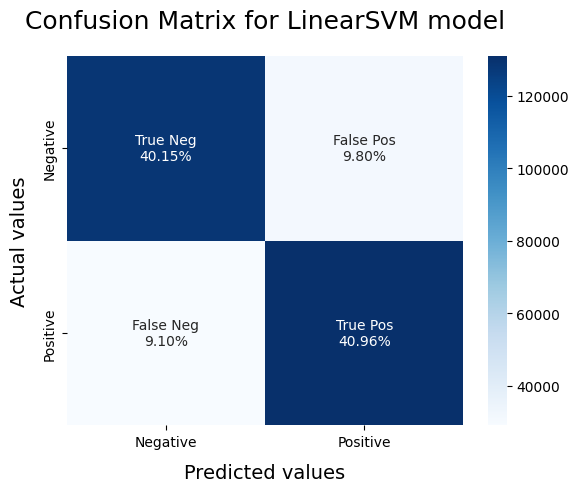

In [29]:
# print results
createConfusionMatrix(y_pred_svm, 'LinearSVM')

### Multinomial Naive Bayes

In [30]:
# initialize model
mnb = MultinomialNB()

mnb_pipeline = createPipeline(mnb)

In [31]:
# predict and evaluate
y_pred_mnb = evaluateModel(mnb_pipeline, X_test)

              precision    recall  f1-score   support

    Negative       0.79      0.81      0.80    159815
    Positive       0.80      0.79      0.79    160185

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000



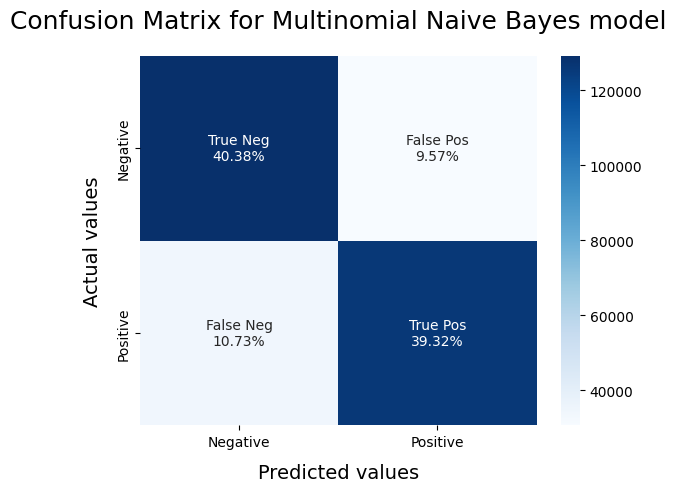

In [32]:
# print results
createConfusionMatrix(y_pred_mnb, 'Multinomial Naive Bayes')

### Decision Tree Classifier

In [33]:
# initialize model
dtc = DecisionTreeClassifier(max_depth=5)

dtc_pipeline = createPipeline(dtc)

In [34]:
# predict and evaluate
y_pred_dtc = evaluateModel(dtc_pipeline, X_test)

              precision    recall  f1-score   support

    Negative       0.60      0.68      0.64    159815
    Positive       0.63      0.55      0.59    160185

    accuracy                           0.61    320000
   macro avg       0.61      0.61      0.61    320000
weighted avg       0.61      0.61      0.61    320000



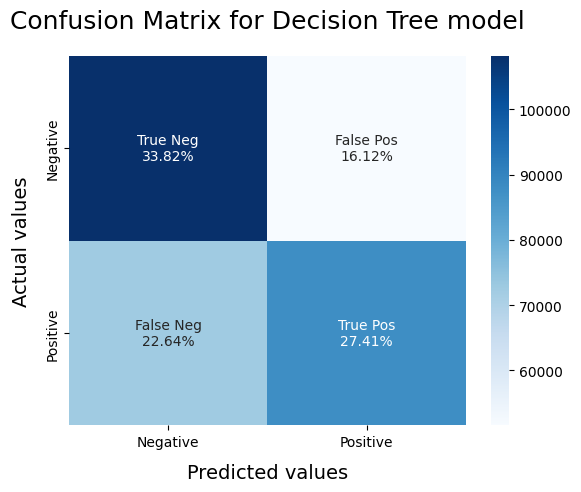

In [41]:
# print results
createConfusionMatrix(y_pred_dtc, 'Decision Tree')

### Logistic Regression

In [44]:
# initialize model
lr = LogisticRegression(solver='liblinear', random_state=0)

lr_pipeline = createPipeline(lr)

In [45]:
# predict and evaluate
y_pred_lr = evaluateModel(lr_pipeline, X_test)

              precision    recall  f1-score   support

    Negative       0.83      0.81      0.82    159815
    Positive       0.82      0.83      0.83    160185

    accuracy                           0.82    320000
   macro avg       0.82      0.82      0.82    320000
weighted avg       0.82      0.82      0.82    320000



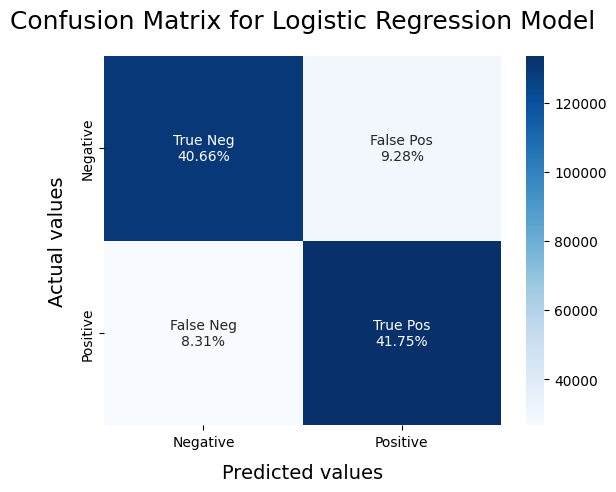

In [47]:
# print results
createConfusionMatrix(y_pred_lr, 'Logistic Regression')

# Deep Learning

## Feature Extraction
Here I will be using word embedding which is used to understand the context of a word in a text. Specifically using GloVe

In [56]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2024-04-26 09:56:45--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-04-26 10:00:08--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-04-26 10:09:12--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

## Preparing the embedding layer

In [72]:
# Reformat the labels to 0 and 1 for negative and positive respectively
le = LabelEncoder()
dl_y_train = le.fit_transform(y_train)
dl_y_test = le.fit_transform(y_test)

In [62]:
# Embedding layer expects the words to be in numeric form
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer
# Method texts_to_sequences converts sentences to their numeric form
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)
dl_X_train = word_tokenizer.texts_to_sequences(X_train)
dl_X_test = word_tokenizer.texts_to_sequences(X_test)


# Adding 1 to store dimensions for words for which no pretrained word embeddings exist
vocab_length = len(word_tokenizer.word_index) + 1

# Padding all reviews to fixed length 100
maxlen = 300
dl_X_train = pad_sequences(dl_X_train, padding='post', maxlen=maxlen)
dl_X_test = pad_sequences(dl_X_test, padding='post', maxlen=maxlen)

In [63]:
embeddings_dictionary = dict()
glove_file = open('glove.6B.300d.txt', encoding="utf8")
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

# Create Embedding Matrix having 100 columns 
# Containing 300-dimensional GloVe word embeddings for all words in our corpus.
embedding_matrix = np.zeros((vocab_length, 300))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# Print Embedding Matrix shape
embedding_matrix.shape

(234479, 300)

## Helper Functions

In [57]:
def displayAccLoss(acc, val_acc, loss, val_loss):
    # plot accuracy
    plt.plot(acc)
    plt.plot(val_acc)
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # plot loss
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

## Neural Networks
I will be training 2 NNs:
- Simple NN
- 1D CNN


### Simple NN

In [77]:
# Build architecture
snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 300, weights=[embedding_matrix], input_length=maxlen, trainable=False)

snn_model.add(embedding_layer)
snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

In [78]:
# Compile model
snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(snn_model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 300)          70343700  
                                                                 
 flatten_2 (Flatten)         (None, 90000)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                 90001     
                                                                 
Total params: 70,433,701
Trainable params: 90,001
Non-trainable params: 70,343,700
_________________________________________________________________
None


In [79]:
# Train the model
snn_model_hist = snn_model.fit(dl_X_train, dl_y_train, batch_size=128, epochs=8, verbose=1, validation_split=0.2)

Epoch 1/8
8000/8000 [==============================] - 42s 5ms/step - loss: 0.5522 - accuracy: 0.7261 - val_loss: 0.5491 - val_accuracy: 0.7319
Epoch 2/8
8000/8000 [==============================] - 42s 5ms/step - loss: 0.5460 - accuracy: 0.7320 - val_loss: 0.5518 - val_accuracy: 0.7301
Epoch 3/8
8000/8000 [==============================] - 41s 5ms/step - loss: 0.5448 - accuracy: 0.7329 - val_loss: 0.5496 - val_accuracy: 0.7283
Epoch 4/8
8000/8000 [==============================] - 39s 5ms/step - loss: 0.5441 - accuracy: 0.7337 - val_loss: 0.5497 - val_accuracy: 0.7332
Epoch 5/8
8000/8000 [==============================] - 39s 5ms/step - loss: 0.5437 - accuracy: 0.7341 - val_loss: 0.5463 - val_accuracy: 0.7321
Epoch 6/8
8000/8000 [==============================] - 39s 5ms/step - loss: 0.5432 - accuracy: 0.7342 - val_loss: 0.5448 - val_accuracy: 0.7337
Epoch 7/8
8000/8000 [==============================] - 39s 5ms/step - loss: 0.5430 - accuracy: 0.7344 - val_loss: 0.5473 - val_accuracy:

In [80]:
# Predictions
snn_score = snn_model.evaluate(dl_X_test, dl_y_test, verbose=1)

# Model Performance
print("Test Loss:", snn_score[0])
print("Test Accuracy:", snn_score[1])

10000/10000 [==============================] - 14s 1ms/step - loss: 0.5447 - accuracy: 0.7366
Test Score: 0.5447112917900085
Test Accuracy: 0.7365968823432922


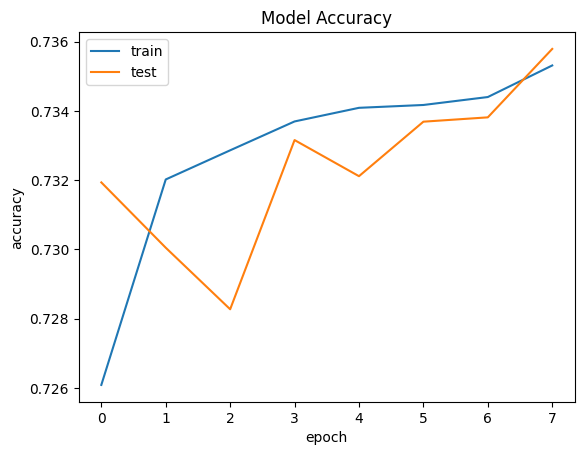

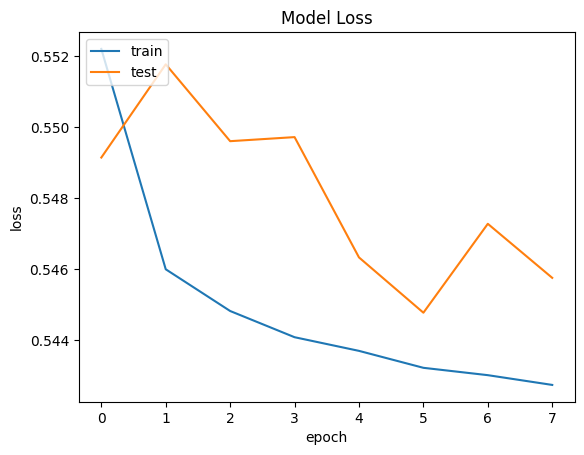

In [81]:
# Display accuracy and loss as graphs
displayAccLoss(
    snn_model_hist.history['accuracy'], 
    snn_model_hist.history['val_accuracy'],
    snn_model_hist.history['loss'],
    snn_model_hist.history['val_loss']
)

### CNN

In [82]:
# Build architecture
cnn_model = Sequential()
embedding_layer = Embedding(vocab_length, 300, weights=[embedding_matrix], input_length=maxlen, trainable=False)

cnn_model.add(embedding_layer)
cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [85]:
# Compile model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(cnn_model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 300, 300)          70343700  
                                                                 
 conv1d (Conv1D)             (None, 296, 128)          192128    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 70,535,957
Trainable params: 192,257
Non-trainable params: 70,343,700
_________________________________________________________________
None


In [87]:
# Train the model
cnn_model_hist = cnn_model.fit(dl_X_train, dl_y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
8000/8000 [==============================] - 1295s 162ms/step - loss: 0.3880 - accuracy: 0.8250 - val_loss: 0.4176 - val_accuracy: 0.8096
Epoch 2/6
8000/8000 [==============================] - 1283s 160ms/step - loss: 0.3753 - accuracy: 0.8323 - val_loss: 0.4237 - val_accuracy: 0.8079
Epoch 3/6
8000/8000 [==============================] - 1270s 159ms/step - loss: 0.3647 - accuracy: 0.8379 - val_loss: 0.4294 - val_accuracy: 0.8037
Epoch 4/6
8000/8000 [==============================] - 1275s 159ms/step - loss: 0.3566 - accuracy: 0.8420 - val_loss: 0.4329 - val_accuracy: 0.8031
Epoch 5/6
8000/8000 [==============================] - 1289s 161ms/step - loss: 0.3489 - accuracy: 0.8464 - val_loss: 0.4344 - val_accuracy: 0.8032
Epoch 6/6
8000/8000 [==============================] - 1293s 162ms/step - loss: 0.3423 - accuracy: 0.8499 - val_loss: 0.4409 - val_accuracy: 0.8034


In [88]:
# Predictions
cnn_score = cnn_model.evaluate(dl_X_test, dl_y_test, verbose=1)

# Model Performance
print("Test Loss:", cnn_score[0])
print("Test Accuracy:", cnn_score[1])

10000/10000 [==============================] - 189s 19ms/step - loss: 0.4372 - accuracy: 0.8050
Test Loss: 0.437181293964386
Test Accuracy: 0.8050468564033508


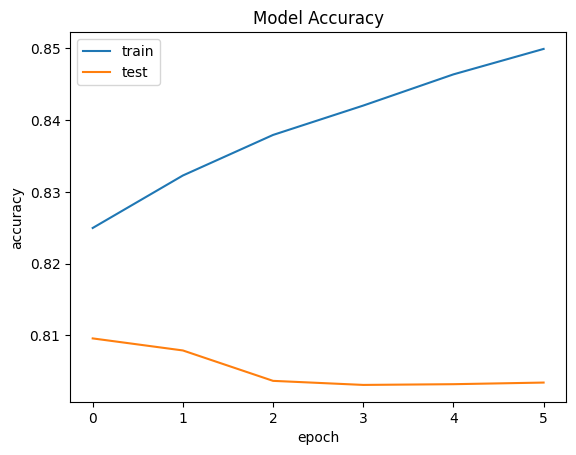

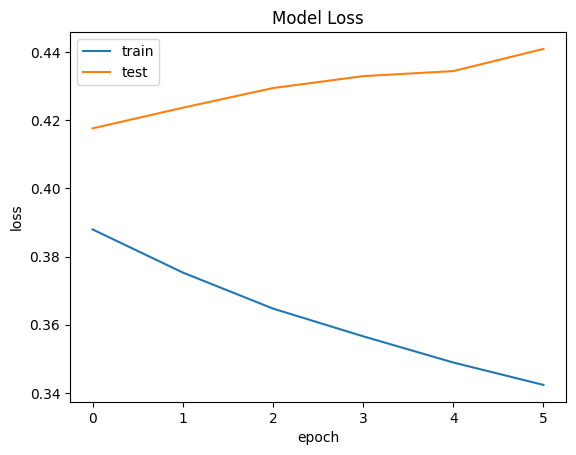

In [89]:
# Display accuracy and loss as graphs
displayAccLoss(
    cnn_model_hist.history['accuracy'],
    cnn_model_hist.history['val_accuracy'],
    cnn_model_hist.history['loss'],
    cnn_model_hist.history['val_loss']
)